# Timeseries analysis LDA
* use static feature generation and LDA on timeseries windows of different size and compare accuracies for possible online prediction model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# own libraries
import importlib
import utilities.filter_acc_data as filter_acc_data
import utilities.feature_generation as feature_generation
import utilities.data_controller as data_controller
importlib.reload(filter_acc_data)
importlib.reload(feature_generation)
importlib.reload(data_controller)

<module 'utilities.data_controller' from 'C:\\Users\\phil\\university\\verona\\machine-learning-project-human-activity-recognition\\utilities\\data_controller.py'>

In [3]:
# read all acc and gyro data
filepath_raw = 'dataset/HAPT-Dataset/'
all_acc_data, all_gyro_data = data_controller.get_all_acc_and_gyro_data_from_txt(filepath_raw)

# get labels and indexes for each activity
label_translation, activity_indexes = data_controller.get_label_and_activity_indexes_from_txt(filepath_raw)

# turn acc data into gravity and body components using low and highpass filter
# Filter settings
sample_frequenzy = 50.0
cutoff_low_hz = 0.25
cutoff_high_hz = 20
filter_order = 3

grav_and_body_acc_data = \
    [filter_acc_data.get_gravitational_and_body_components(acc_data, sample_frequenzy, cutoff_low_hz, cutoff_high_hz, filter_order) 
     for acc_data in all_acc_data]

all_acc_gravity_data = [grav_data[0] for grav_data in grav_and_body_acc_data]
all_acc_body_data = [grav_data[1] for grav_data in grav_and_body_acc_data]
all_acc_noise_data = [grav_data[2] for grav_data in grav_and_body_acc_data]

data = data_controller.transform_raw_data_into_data_object(label_translation, activity_indexes, all_acc_data, all_acc_gravity_data, all_acc_body_data, all_gyro_data, all_acc_noise_data)

# get timeseries data and labels
timeseries_data = []
timeseries_labels = []
activities_to_use = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
for activity in data:
    if activity['name'] not in activities_to_use:
        continue
    for activity_data in activity['data']:
        timeseries_data.append(activity_data)
        timeseries_labels.append(activity['name'])

In [4]:
accuracies = []

In [5]:
# the timeseries data has different lengths. To solve this, we create multiple timeframes of the same length.
# If a timeframe is longer, we split it into multiple timeframes of the same length. If it is shorter, we discard it.
# TODO: maybe if timeframe snippet is to short fill up with zeroes instead of discarding
# We also let each timeframe overlap
for window_size in range(25, 201, 25):
    X = None
    y = []
    overlapping_size = min(40, window_size)
    for i in range(len(timeseries_data)):
        timeseries = timeseries_data[i]
        label = timeseries_labels[i]
        for j in range(0, len(timeseries), overlapping_size):
            if j + window_size > len(timeseries):
                # discard to short time snippets
                break
            # here timeseries needs to be turned into static features
            static_features = feature_generation.generate_features_for_static_timeseries_window(timeseries[j:j+window_size])
            if X is None:
                X = pd.DataFrame(columns=static_features.keys())
            X.loc[len(X.index)] = static_features
            y.append(label)
    X = np.array(X)
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1905)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print(confusion_matrix(y_test, y_pred))
    accuracies.append({'window_size': window_size, 'confusion_matrix': confusion_matrix(y_test, y_pred), 'accuracy': accuracy})

Accuracy: 0.8979488048821834
[[1064    0    0    0    0    0]
 [  14  763  201    0    0    1]
 [   0  133  976    0    0    2]
 [   0    0    0  911   21   25]
 [   0    2    0   56  769   66]
 [   0    0    0   52   29  814]]
Accuracy: 0.9241417497231451
[[659   0   0   0   0   0]
 [  3 504 113   0   0   2]
 [  0  71 598   0   0   2]
 [  0   0   0 577   2   4]
 [  0   0   0  20 465  23]
 [  0   0   0  30   4 535]]
Accuracy: 0.929243937232525
[[626   0   0   0   0   0]
 [  7 500 113   0   0   0]
 [  0  60 575   1   0   0]
 [  0   0   0 548   3   3]
 [  0   1   0  15 467  19]
 [  0   0   0  20   6 541]]
Accuracy: 0.9385113268608414
[[636   0   0   0   0   0]
 [  3 478 103   0   0   0]
 [  0  57 545   0   0   0]
 [  0   0   0 549   2   2]
 [  0   0   0   6 469   8]
 [  0   0   0  26   2 513]]
Accuracy: 0.9419981779532342
[[615   0   0   0   0   0]
 [  8 469  99   0   0   0]
 [  0  52 588   0   0   0]
 [  0   0   0 534   0   0]
 [  0   0   0   7 417   4]
 [  0   0   0  20   1 479]]
Accur

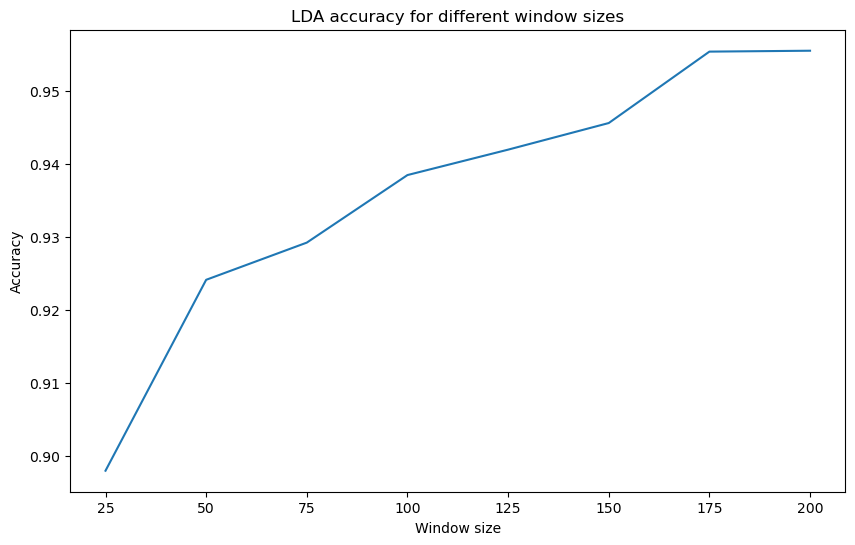

In [8]:
# set figsize
plt.figure(figsize=(10, 6))
plt.plot([accuracy['window_size'] for accuracy in accuracies], [accuracy['accuracy'] for accuracy in accuracies])
plt.xlabel('Window size')
plt.ylabel('Accuracy')
plt.title('LDA accuracy for different window sizes')
plt.show()